# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1

### 1. Loading data

In [1]:
#loading the fst package
#install.packages("fst")
library(fst)

Warning message:
"package 'fst' was built under R version 4.1.3"


In [31]:
#reading data
data_BAC_full <- read_fst("HW_3_data/HW_3_BAC_1min.fst")
data_MSFT_full <- read_fst("HW_3_data/HW_3_MSFT_1min.fst")
data_XOM_full <- read_fst("HW_3_data/HW_3_XOM_1min.fst")

In [7]:
#basic data exploration, to be removed later
summary(data_BAC)
summary(data_MSFT)
summary(data_XOM)

     index                           V1        
 Min.   :2010-01-04 07:00:00   Min.   : 4.601  
 1st Qu.:2011-11-30 15:15:15   1st Qu.:11.239  
 Median :2013-11-22 10:39:30   Median :14.030  
 Mean   :2013-12-13 06:31:08   Mean   :14.205  
 3rd Qu.:2015-12-24 10:24:45   3rd Qu.:16.056  
 Max.   :2017-12-29 17:59:00   Max.   :29.796  

     index                           V1       
 Min.   :2010-01-04 07:44:00   Min.   :18.43  
 1st Qu.:2011-12-08 08:45:00   1st Qu.:23.52  
 Median :2013-12-18 15:51:00   Median :32.80  
 Mean   :2013-12-27 07:27:58   Mean   :37.81  
 3rd Qu.:2016-01-08 16:04:00   3rd Qu.:48.79  
 Max.   :2017-12-29 18:00:00   Max.   :86.52  

     index                           V1       
 Min.   :2010-01-04 07:01:00   Min.   :43.45  
 1st Qu.:2011-11-28 14:52:30   1st Qu.:65.99  
 Median :2013-12-18 11:05:00   Median :74.10  
 Mean   :2013-12-18 02:42:53   Mean   :71.51  
 3rd Qu.:2015-12-23 12:52:30   3rd Qu.:79.09  
 Max.   :2017-12-29 17:56:00   Max.   :90.13  

In [11]:
sum(is.na(data_BAC$V1))
sum(is.na(data_MSFT$V1))
sum(is.na(data_XOM$V1))

[1] 0

[1] 0

[1] 0

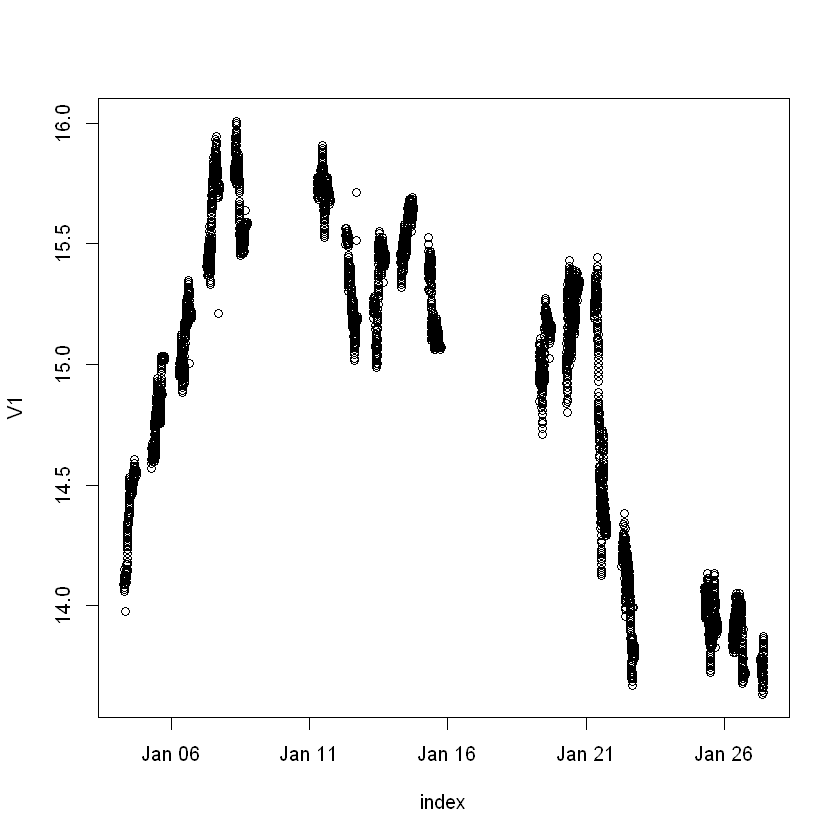

In [29]:
#plot(data_BAC) #<------takes 1 minute to plot
plot(data_BAC[1:10000,])

#as usual, we have data on workdays (because stock-exchanges serves need to rest for 2 days)

In [30]:
data_BAC[1:100000,]

,index,V1
,<dttm>,<dbl>
1,2010-01-04 07:00:00,14.0864
2,2010-01-04 07:04:00,14.0864
3,2010-01-04 07:06:00,14.0679
4,2010-01-04 07:08:00,14.0586
5,2010-01-04 07:13:00,14.0772
6,2010-01-04 07:21:00,14.1050
7,2010-01-04 07:23:00,14.1236
8,2010-01-04 07:25:00,14.1236
9,2010-01-04 07:27:00,14.1236


### 2. Restricting data

In [67]:
data_BAC <- subset(data_BAC_full, format(data_BAC_full$index,'%Y') >= '2012' & 
                        format(data_BAC_full$index,'%Y') <= '2016' &
                        format(data_BAC_full$index,'%H:%M') >= '09:30' &
                        format(data_BAC_full$index,'%H:%M') <= '16:00')

data_MSFT <- subset(data_MSFT_full, format(data_MSFT_full$index,'%Y') >= '2012' & 
                        format(data_MSFT_full$index,'%Y') <= '2016' &
                        format(data_MSFT_full$index,'%H:%M') >= '09:30' &
                        format(data_MSFT_full$index,'%H:%M') <= '16:00')

data_XOM <- subset(data_XOM_full, format(data_XOM_full$index,'%Y') >= '2012' & 
                        format(data_XOM_full$index,'%Y') <= '2016' &
                        format(data_XOM_full$index,'%H:%M') >= '09:30' &
                        format(data_XOM_full$index,'%H:%M') <= '16:00')                                                


In [66]:
summary(data_BAC)

     index                           V1        
 Min.   :2012-01-03 09:30:00   Min.   : 5.256  
 1st Qu.:2013-04-05 11:59:30   1st Qu.:11.456  
 Median :2014-07-07 10:19:00   Median :14.291  
 Mean   :2014-07-04 09:45:42   Mean   :13.364  
 3rd Qu.:2015-10-02 12:23:30   3rd Qu.:15.624  
 Max.   :2016-12-30 16:00:00   Max.   :22.841  